In [1]:
from scqubits.settings import matplotlib_settings
import matplotlib as mpl
from matplotlib.axes import Axes
from scqubits.utils.plot_utils import _extract_kwargs_options
from numpy import ndarray
from scqubits.utils.misc import InfoBar, process_which
import scqubits.core.constants as constants
from scqubits.utils.spectrum_utils import (
    get_matrixelement_table,
    order_eigensystem,
    recast_esys_mapdata,
    standardize_sign,
)
from scqubits.utils.plot_utils import (
    _extract_kwargs_options,
    _process_options,
    add_numbers_to_axes,
    color_normalize,
    plot_potential_to_axes,
    plot_wavefunction_to_axes,
    scale_wavefunctions,
)
import scqubits.utils.misc as utils
from scqubits.core.discretization import Grid1d


In [2]:
import matplotlib.gridspec as gridspec

import sys
original_sys_path = sys.path.copy()
from CoupledQuantumSystems.visualization import *
import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
linestyles = ['-','-','--']
linewidth_list = [1.75,1.75,1]


In [3]:
from typing import List
@mpl.rc_context(matplotlib_settings)
def plot_wavefunction(
    qbt,
    phi_grid,
    which = 0,
    colors = None,
    fill = List[bool],
    dashed = List[bool],
    lw = List[float],
    mode= "real",
    scaling = None,
    fig_ax = None,
    
):
    if fill is None:
        fill = [False for i in colors]
    if dashed is None:
        dashed = [False for i in colors]
    if lw is None:
        lw = [1.0 for i in colors]
    wavefunc_indices = process_which(which, qbt.truncated_dim)

    evals_count = max(wavefunc_indices) + 1
    esys = qbt.eigensys(evals_count=evals_count)
    evals, _ = esys

    if colors == None:
        colors = ['grey' for _ in range(len(evals))]

    energies = evals[list(wavefunc_indices)]

    potential_vals = qbt.potential(phi_grid.make_linspace())

    amplitude_modifier = constants.MODE_FUNC_DICT[mode]
    wavefunctions = []
    for wavefunc_index in wavefunc_indices:
        phi_wavefunc = qbt.wavefunction(
            esys, which=wavefunc_index, phi_grid=phi_grid
        )
        phi_wavefunc.amplitudes = standardize_sign(phi_wavefunc.amplitudes)
        phi_wavefunc.amplitudes = amplitude_modifier(phi_wavefunc.amplitudes)
        wavefunctions.append(phi_wavefunc)

    wavefunction1d(
        wavefunctions,
        potential_vals=potential_vals,  # type:ignore
        offset=energies,
        scaling=scaling,
        colors = colors,
        fill = fill,
        dashed = dashed,
        lw=lw,
        fig_ax = fig_ax
    )
    return fig_ax

@mpl.rc_context(matplotlib_settings)
def wavefunction1d(
    wavefuncs,
    potential_vals,
    offset,
    scaling,
    colors,
    fill,
    dashed,
    lw,
    fig_ax
):

    fig, axes = fig_ax
    offset_list = utils.to_list(offset)
    wavefunc_list = utils.to_list(wavefuncs)
    wavefunc_list = scale_wavefunctions(wavefunc_list, potential_vals, scaling)

    for wavefunction, energy_offset,color,fill_this,dash_this,lw_this in zip(wavefunc_list, offset_list,colors,fill,dashed,lw):
        plot_wavefunction_to_axes(axes, wavefunction, energy_offset,color=color,fill_this=fill_this,dash_this=dash_this,lw_this=lw_this)

    x_vals = wavefunc_list[0].basis_labels
    plot_potential_to_axes(axes, x_vals, potential_vals, offset_list)
    return fig, axes

@mpl.rc_context(matplotlib_settings)
def plot_wavefunction_to_axes(
    axes,
      wavefunction,
      energy_offset,
      color,
      fill_this,
      dash_this,
      lw_this
) -> None:
    x_vals = wavefunction.basis_labels
    y_vals = energy_offset + wavefunction.amplitudes
    offset_vals = [energy_offset] * len(x_vals)

    axes.plot(x_vals, y_vals,color = color, alpha=1.0,linestyle = '--' if dash_this else '-',linewidth = lw_this)
    if fill_this:
        axes.fill_between(
            x_vals, y_vals, offset_vals,color = color, alpha=0.5,where=(y_vals != offset_vals), interpolate=True
        )

@mpl.rc_context(matplotlib_settings)
def plot_potential_to_axes(
    axes,
    x_vals,
    potential_vals,
    offset_list,
) -> None:
    y_min = np.min(potential_vals)
    y_max = np.max(offset_list)
    y_range = y_max - y_min
    y_max += 0.3 * y_range
    y_min = np.min(potential_vals) - 0.1 * y_range
    axes.set_ylim([y_min, y_max])
    axes.plot(
        x_vals, potential_vals, color="black", linewidth=0.5
    )


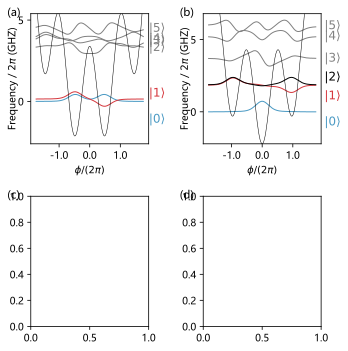

In [35]:
fig,axes = plt.subplots(2,2,figsize=(5,5))

wave_func_scaling = 0.5

def plot(fig,ax):
    n_evals = 20
    qbt = scqubits.Fluxonium(EJ = 3,EC =3/3,EL = 3/30, cutoff = 110,flux = 0.5,truncated_dim=n_evals)
    omega_0 = qbt.eigenvals()[0]

    color_used = ['#4999c3', '#d5373d']+['grey']*4
    dashed = [0]*6
    fill = None
    lw = [1.0]*6
    fig, ax = plot_wavefunction( qbt, which=list(range(6)),colors = color_used,
                                                                    fill = fill,
                                                                    fig_ax =(fig, ax ),
                            scaling=wave_func_scaling,
                            phi_grid=Grid1d(min_val=  -3.5*np.pi, max_val= 3.5*np.pi, pt_count= 151) ,
                            dashed =  dashed,lw=lw)

    ax.set_xticks(np.array([-1,0,1])*2* np.pi)
    current_ticks = ax.get_xticks()
    modified_ticks = current_ticks /(2* np.pi)
    ax.set_xticklabels([f'{val:.1f}' for val in modified_ticks])
    ax.set_xlabel(r"$\phi/(2\pi)$")

    ax.set_yticks(np.array([0,5,10,15,20,25])+omega_0)
    # ax.set_yticks(np.array([0,30/(2*np.pi),60/(2*np.pi),90/(2*np.pi)])+omega_0  )
    current_ticks = ax.get_yticks()
    modified_ticks = current_ticks - omega_0
    # ax.set_yticklabels([f'{val*2*np.pi:.0f}' for val in modified_ticks])
    ax.set_yticklabels([f'{val:.0f}' for val in modified_ticks])
    ax.set_ylabel(rf'''Frequency / $2\pi$ (GHZ)''',labelpad = 0)
    # ax.set_ylabel(rf'''Frequency (GHz)''',labelpad = 0)
    ax.set_ylim(-3,5)

    evals = qbt.eigenvals(evals_count=20)
    evals[0] = -1.5
    evals[1] = 0.1
    for ql in [0,1,2,3,4,5]:
        ax.text(2.2*2*np.pi,evals[ql],rf"$|{ql}\rangle$",ha='center',va='center', fontsize=12,color=color_used[ql])
plot(fig,axes[0,0] )

def plot(fig,ax):
    n_evals = 20
    qbt = scqubits.Fluxonium(EJ = 3,EC = 3/3,EL = 3/30, cutoff = 110,flux = 0,truncated_dim=n_evals)

    omega_0 = qbt.eigenvals()[0]
    color_used = ['#4999c3', '#d5373d', 'black']+['grey']*4
    dashed = [0]*7
    lw = [1.0]*7
    fill = None
    fig, ax = plot_wavefunction( qbt, which=list(range(7)),colors = color_used,
                                                            fill = fill,
                                                            fig_ax =(fig, ax ),
                            scaling=wave_func_scaling,
                            phi_grid=Grid1d(min_val=  -3.5*np.pi, max_val= 3.5*np.pi, pt_count= 151) ,
                             dashed=dashed,lw=lw )
    ax.set_xticks(np.array([-1,0,1])*2* np.pi)
    current_ticks = ax.get_xticks()
    modified_ticks = current_ticks /(2* np.pi)
    ax.set_xticklabels([f'{val:.1f}' for val in modified_ticks])
    ax.set_xlabel(r"$\phi/(2\pi)$")

    ax.set_yticks(np.array([0,5,10])+omega_0)
    # ax.set_yticks(np.array([0,30/(2*np.pi),60/(2*np.pi),90/(2*np.pi)])+omega_0  )
    current_ticks = ax.get_yticks()
    modified_ticks = current_ticks - omega_0
    # ax.set_yticklabels([f'{val*2*np.pi:.0f}' for val in modified_ticks])
    ax.set_yticklabels([f'{val:.0f}' for val in modified_ticks])
    ax.set_ylabel(rf'''Frequency / $2\pi$ (GHZ)''',labelpad = 0)
    # ax.set_ylabel(rf'''Frequency (GHz)''',labelpad = 0)
    ax.set_ylim(-3,6)

    evals = qbt.eigenvals(evals_count=10)
    evals[0] = -1.5
    evals[1] = 0.3
    evals[2] = 1.6
    for ql in [0,1,2,3,4,5]:
        ax.text(2.3*2*np.pi,evals[ql],rf"$|{ql}\rangle$",ha='center',va='center', fontsize=12,color=color_used[ql])
plot(fig,axes[0,1] )


axes[0, 0].text(-0.2, 1.05, '(a)', transform=axes[0, 0].transAxes, fontsize=11, va='top', color='black')
axes[0, 1].text(-0.2, 1.05, '(b)', transform=axes[0, 1].transAxes, fontsize=11, va='top', color='black')
axes[1, 0].text(-0.2, 1.05, '(c)', transform=axes[1, 0].transAxes, fontsize=11, va='top', color='black')
axes[1, 1].text(-0.2, 1.05, '(d)', transform=axes[1, 1].transAxes, fontsize=11, va='top', color='black')

plt.tight_layout()
fig.savefig('wavefuncs_three_lvl.pdf')